In [5]:
pip install scikit-learn==1.4.1.post1 seaborn==0.13.2 fasteda==1.0.1


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 2.0 MB/s eta 0:00:06
   ---------------------------------------- 0.0/10.6 MB 2.0 MB/s eta 0:00:06
   ---------------------------------------- 0.1/10.6 MB 550.5 kB/s eta 0:00:20
   ---------------------------------------- 0.1/10.6 MB 512.0 kB/s eta 0:00:21
   ---------------------------------------- 0.1/10.6 MB 403.5 kB/s eta 0:00:27
   ---------------------------------------- 0.1/10.6 MB 403.5 kB/s eta 0:00:27
   ---------------------------------------- 0.1/10.6 MB 380.5 kB/s eta 0:00:28
    --------------------------------------- 0.2/10.6 MB 409.6 kB/s eta 0:00:26
    --------------------------------------- 0.2/10.6 MB 409.6 kB/s eta 0:00:26
    --------------------------------------- 0.2/10.6 MB 402.0 kB/s eta 0:00:26
    -------------------------------------

In [89]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import root_mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from fasteda import fast_eda
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

In [94]:
diabetes_X, diabetes_y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
print(type(diabetes_y))

<class 'pandas.core.series.Series'>


In [108]:
diabetes = pd.concat ([diabetes_X, diabetes_y], axis = 1).rename ({0: 'target'}, axis = 1) 
diabetes_default = load_diabetes()
diabetes.sample(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
276,52.0,1.0,28.8,113.0,280.0,174.0,67.0,4.0,5.2730,86.0,283.0
419,43.0,1.0,21.3,79.0,141.0,78.8,53.0,3.0,3.8286,90.0,42.0
432,51.0,1.0,31.5,93.0,231.0,144.0,49.0,4.7,5.2523,117.0,173.0
175,67.0,1.0,22.8,87.0,166.0,98.6,52.0,3.0,4.3438,92.0,127.0
161,36.0,2.0,32.3,115.0,286.0,199.4,39.0,7.0,5.4723,112.0,217.0


In [110]:
diabetes.isna().max(axis = 0).max()

False

In [112]:
#Introducing missing values to the data:
import random
random.seed(2024)
#Selecting 3 columns at random: 
missing_columns = random.sample (range(len(diabetes.columns)-1), 3)
"""this code has selected 3 random columns from diabetes colums (-1 implies that the last column has been excluded) and 3 columns is presented by the
3 at the end"""
#Selecting 10% of the rows at random: 
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/10)))
"""the parameters passed under this code is the diabetes.index.tolist() where we are drawing our random sample, and we are selecting
10% of the length of the index to list"""
#Now we have already selected 3 random columns and 10% of the rows, we set this to missing values, effectively replacing the values that were there
"""the iloc[] method locates the cells and replaces them with np.nan (not a number)"""
diabetes.iloc[missing_rows, missing_columns] = np.nan

In [114]:
print(sorted(diabetes.columns[missing_columns]))

['bmi', 's1', 's4']


In [116]:
# Initialize the one-hot encoder
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# One-hot encode 'sex'; the output is a numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

# Convert numpy array to pandas DataFrame with columns names based on original category labels
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])

# Horizontally concatenate the original 'diabetes' data set with the two one-hot columns
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Sample 10 rows. Print only the 'sex', 'sex1', and 'sex2' columns for simplicity
diabetes[['sex', 'sex1', 'sex2']].sample(10)


,sex,sex1,sex2
25,2.0,0.0,1.0
269,1.0,1.0,0.0
275,2.0,0.0,1.0
416,1.0,1.0,0.0
249,1.0,1.0,0.0
282,1.0,1.0,0.0
383,2.0,0.0,1.0
111,1.0,1.0,0.0
313,2.0,0.0,1.0
209,2.0,0.0,1.0


In [118]:
# Drop 'sex' and 'sex2'
diabetes = diabetes.drop(['sex', 'sex2'], axis=1)
# Reorder columns to have 'sex1' where 'sex' used to be
diabetes = diabetes.loc[:, ['age', 'sex1', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']]
# Print a sample of 5 rows
diabetes.sample(5)

,age,sex1,bmi,bp,s1,s2,s3,s4,s5,s6,target
304,60.0,0.0,22.8,110.00,245.0,189.8,39.0,6.0,4.3944,88.0,253.0
254,57.0,0.0,31.6,117.00,225.0,107.6,40.0,6.0,5.9584,113.0,310.0
23,61.0,0.0,32.0,103.67,210.0,85.2,35.0,6.0,6.1070,124.0,245.0
49,37.0,0.0,27.7,93.00,180.0,119.4,30.0,6.0,5.0304,88.0,142.0
112,25.0,1.0,28.3,87.00,193.0,128.0,49.0,4.0,4.3820,92.0,246.0


In [124]:
print(diabetes)

      age  sex1   bmi      bp     s1     s2    s3    s4      s5     s6  target
0    59.0   0.0  32.1  101.00  157.0   93.2  38.0  4.00  4.8598   87.0   151.0
1    48.0   1.0  21.6   87.00  183.0  103.2  70.0  3.00  3.8918   69.0    75.0
2    72.0   0.0  30.5   93.00  156.0   93.6  41.0  4.00  4.6728   85.0   141.0
3    24.0   1.0  25.3   84.00  198.0  131.4  40.0  5.00  4.8903   89.0   206.0
4    50.0   1.0  23.0  101.00  192.0  125.4  52.0  4.00  4.2905   80.0   135.0
..    ...   ...   ...     ...    ...    ...   ...   ...     ...    ...     ...
437  60.0   0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0   0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0   0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0   1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0   1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

[442 rows x 11 columns]


In [148]:
X_train, X_test, y_train, y_test = train_test_split(diabetes.iloc[:, :-1], diabetes.iloc[:, [-1]], test_size = 0.33, random_state = 2024)

In [130]:
diabetes.isna().sum()

age        0
sex1       0
bmi       44
bp         0
s1        44
s2         0
s3         0
s4        44
s5         0
s6         0
target     0
dtype: int64

<Axes: >

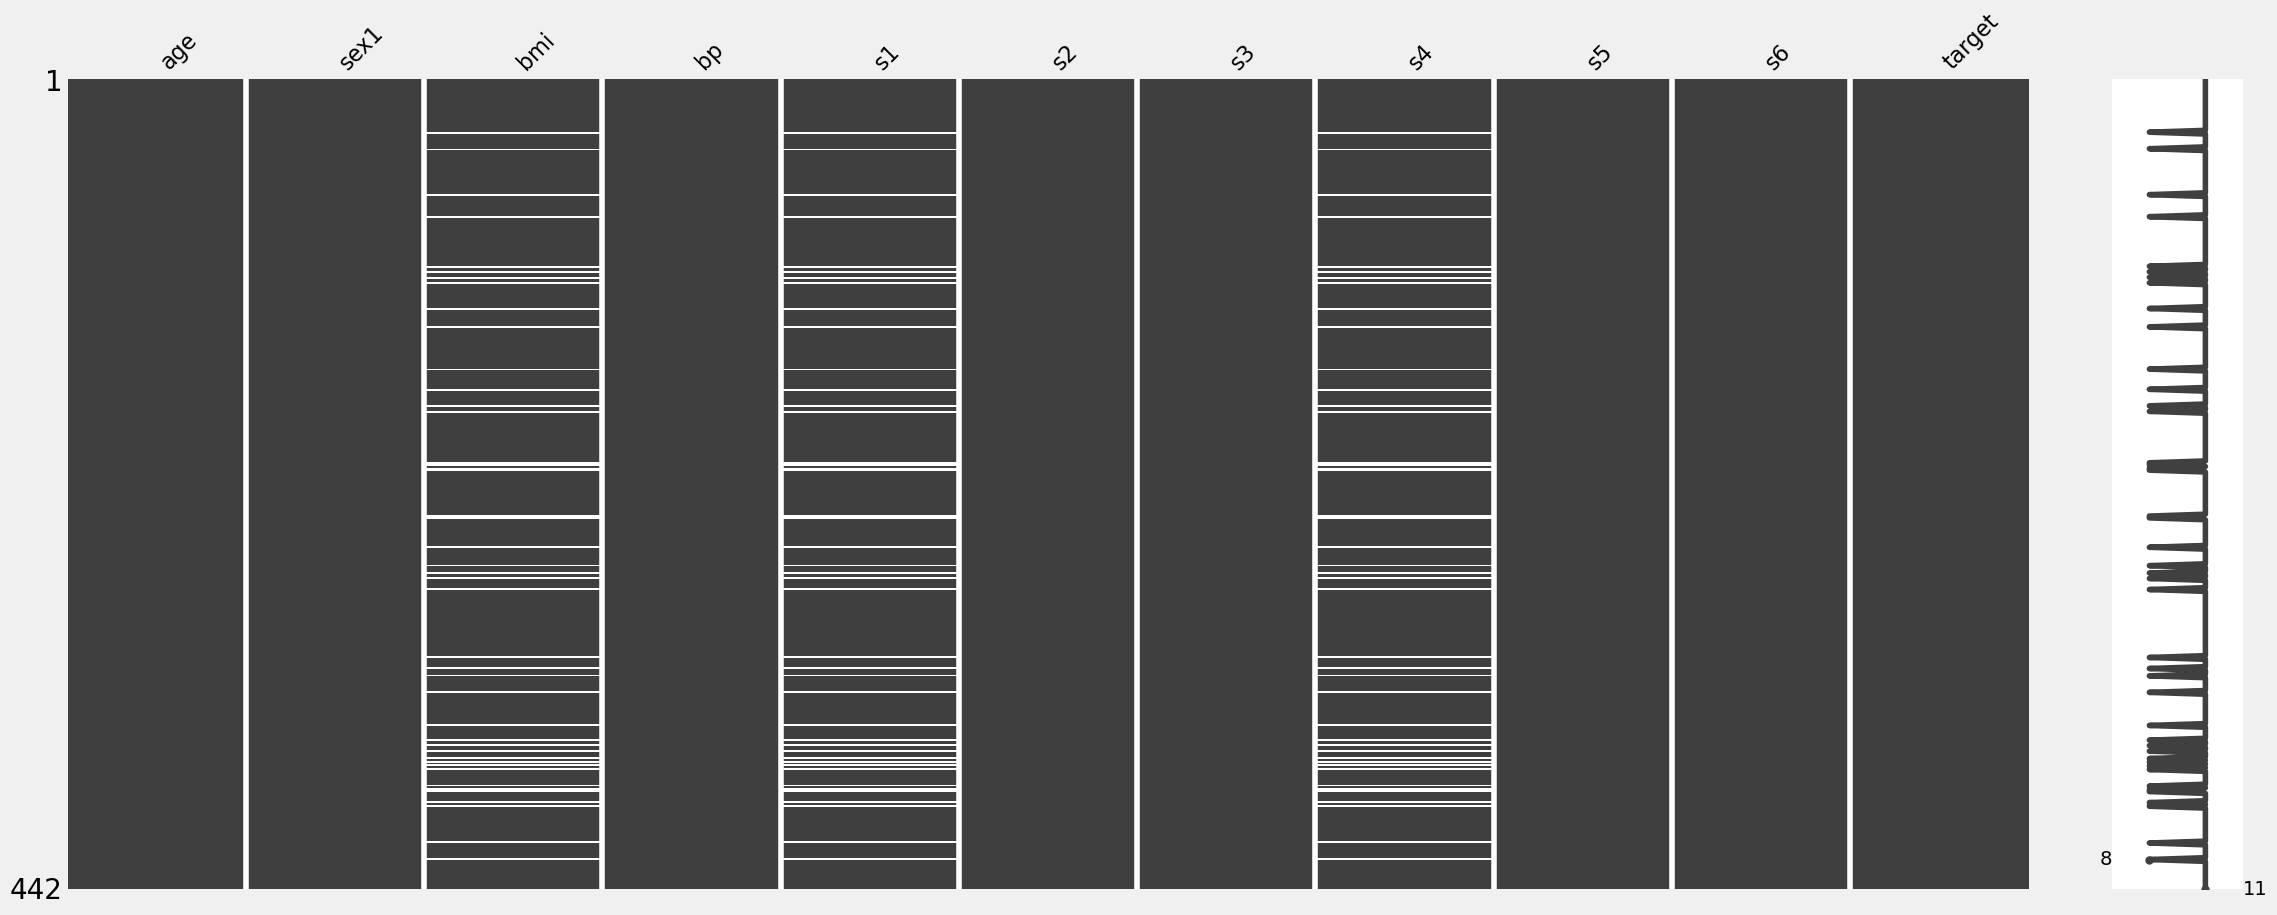

In [132]:
msno.matrix(diabetes)

In [138]:
#still dealing with missing values- identifying the first row with a missing bmi value
diabetes.index[diabetes['bmi'].isna()][0]

29

In [152]:
#Get non Nan Indices, and passing these indices to the loc mathod as Xs and Ys
non_missing_train = X_train.index [~X_train.isna().max(axis=1)]
non_missing_test = X_test.index[~X_test.isna().max(axis=1)]
#Fit the model using non-missing values 
reg=LinearRegression().fit(X_train.loc[non_missing_train], y_train.loc[non_missing_train])
predictions = reg.predict(X_test.loc[non_missing_test])
root_mean_squared_error (y_test.loc[non_missing_test], predictions)

56.02678290578213